### Ejercicio de series de tiempo
* Conjunto de datos: [Clima diario en Delhi](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

##### Preparación

In [1]:
# Importar librerías de análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definir un tema para graficar
sns.set_style('whitegrid')

In [3]:
# Importar módulos de series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [4]:
# Suprimir alertas
import warnings
warnings.filterwarnings("ignore")

##### Preprocesamiento

In [5]:
# Abrir el archivo
df = pd.read_csv('DailyDelhiClimateTest.csv', header=0, sep=',')
df.shape

(114, 5)

In [6]:
# Ver las primeras filas
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
# Ver la información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [8]:
# Convertir la fecha en índice
df['date'] = pd.to_datetime(df['date'], yearfirst=True)
df.set_index('date', inplace=True)
df.index.is_monotonic

True

In [9]:
# Indicar la frecuencia de los datos
# df.index.freq = df.index.inferred_freq
df = df.asfreq('D')

In [10]:
# Contar el número de valores nulos por variable
df.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

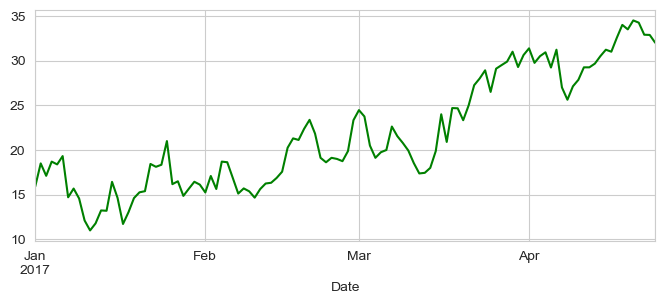

In [11]:
# Graficar la serie
fig, ax = plt.subplots(figsize=(8,3))
df['meantemp'].plot(xlabel='Date', color='green', ax=ax)
plt.show()

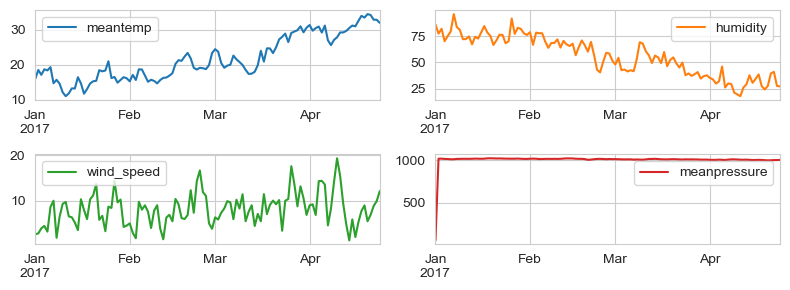

In [12]:
# Graficar todas las series
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,3))
df.plot(subplots=True, xlabel='', ax=ax)
plt.tight_layout()
plt.show()

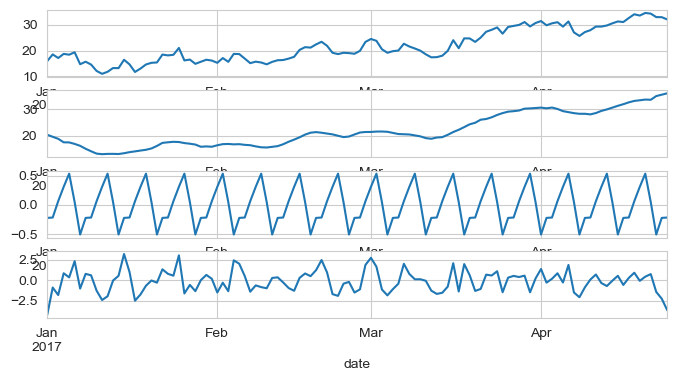

In [13]:
# Hacer una descomposición de la serie
decomp = seasonal_decompose(df['meantemp'], period=7, extrapolate_trend='freq', model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8,4))
decomp.observed.plot(ax=ax1)
decomp.trend.plot(ax=ax2)
decomp.seasonal.plot(ax=ax3)
decomp.resid.plot(ax=ax4)
plt.show()

In [14]:
# Aplicar la prueba Dickey-Fuller
stat, pval = adfuller(df['meantemp'])[:2]
print(f'Estadístico: {stat:.2f}\nP-value: {pval:.2f}'.format(stat, pval))

Estadístico: -1.10
P-value: 0.72


In [15]:
# Transformar la serie
# df['meantemp_diff'] = df['meantemp'] - df['meantemp'].shift()
df['meantemp_diff'] = df['meantemp'].diff()

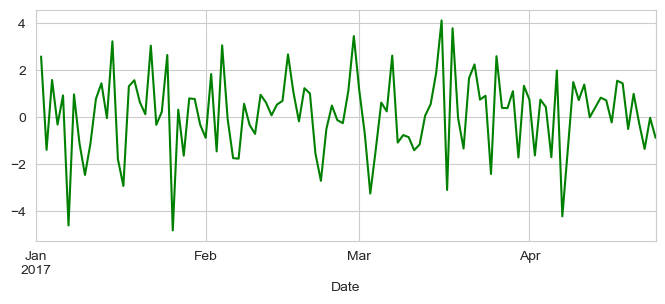

In [16]:
# Graficar la serie diferenciada
fig, ax = plt.subplots(figsize=(8,3))
df['meantemp_diff'].plot(xlabel='Date', color='green', ax=ax)
plt.show()

In [17]:
# Aplicar la prueba Dickey-Fuller
stat, pval = adfuller(df['meantemp_diff'].dropna())[:2]
print(f'Estadístico: {stat:.2f}\nP-value: {pval:.2f}'.format(stat, pval))

Estadístico: -12.04
P-value: 0.00


Se determina que el orden de diferenciación a utilizarse será de uno (d = 1).

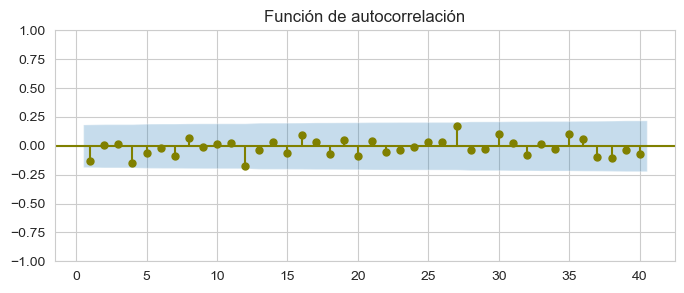

In [18]:
# Graficar la función de autocorrelación (ACF)
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(df.iloc[1:]['meantemp_diff'], lags=40, zero=False, color='olive', vlines_kwargs={'colors': 'olive'}, ax=ax)
ax.set_title('Función de autocorrelación')
plt.show()

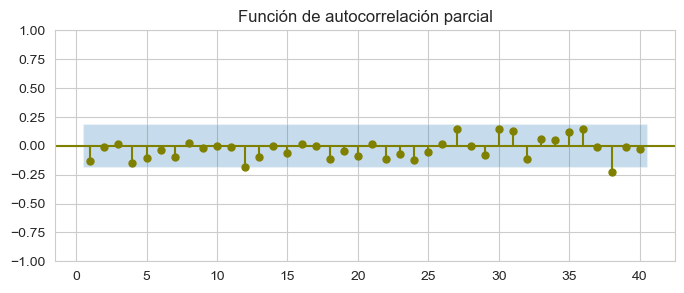

In [19]:
# Graficar la función de autocorrelación parcial (PACF)
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(df.iloc[1:]['meantemp_diff'], lags=40, zero=False, method=('ols'), color='olive', vlines_kwargs={'colors': 'olive'}, ax=ax)
ax.set_title('Función de autocorrelación parcial')
plt.show()

Según la inspección de las funciones ACF y PACF, el modelo ajustado debe ser ARIMA(0,1,0).

In [20]:
# Dividir en entrenamiento y prueba
train = df.loc[:'2017-04-15', 'meantemp']
test = df.loc['2017-04-15':, 'meantemp']
train.shape[0], test.shape[0]

(105, 10)

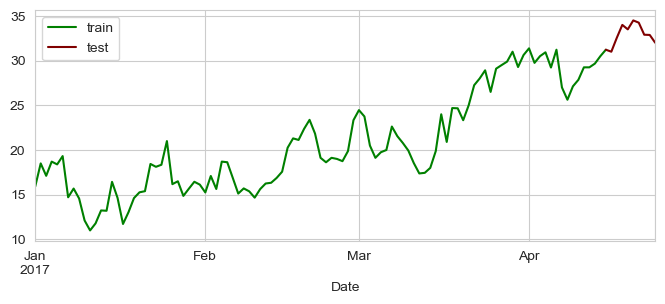

In [21]:
# Graficar la serie dividida
train.plot(figsize=(8,3), label='train', color='green')
test.plot(figsize=(8,3), label='test', color='maroon')
plt.xlabel('Date')
plt.legend()
plt.show()

##### Ajustar el modelo ARIMA

In [22]:
# Definir una malla de parámetros
import itertools

p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], 1, x[2], 7) for x in list(itertools.product(p, [1], q))]

In [23]:
# Buscar los mejores hiperparámetros
from statsmodels.tsa.statespace.sarimax import SARIMAX

aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(train, order = parametros, seasonal_order = parametros_s,
                       enforce_stationarity = False, enforce_invertibility = False)
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))

ARIMA(0, 1, 0) x (0, 1, 0, 7) - AIC:454.3103486475407
ARIMA(0, 1, 0) x (0, 1, 1, 7) - AIC:367.98289195285645
ARIMA(0, 1, 0) x (0, 1, 2, 7) - AIC:343.046535530462
ARIMA(0, 1, 0) x (1, 1, 0, 7) - AIC:395.4607340782185
ARIMA(0, 1, 0) x (1, 1, 1, 7) - AIC:368.6973928764604
ARIMA(0, 1, 0) x (1, 1, 2, 7) - AIC:345.00760377280216
ARIMA(0, 1, 0) x (2, 1, 0, 7) - AIC:353.9996287541147
ARIMA(0, 1, 0) x (2, 1, 1, 7) - AIC:346.830085877097
ARIMA(0, 1, 0) x (2, 1, 2, 7) - AIC:344.3512691690546
ARIMA(0, 1, 1) x (0, 1, 0, 7) - AIC:450.7874166065296
ARIMA(0, 1, 1) x (0, 1, 1, 7) - AIC:366.2078061015632
ARIMA(0, 1, 1) x (0, 1, 2, 7) - AIC:339.12753740491996
ARIMA(0, 1, 1) x (1, 1, 0, 7) - AIC:396.55345707038003
ARIMA(0, 1, 1) x (1, 1, 1, 7) - AIC:366.28057676549133
ARIMA(0, 1, 1) x (1, 1, 2, 7) - AIC:340.737976216572
ARIMA(0, 1, 1) x (2, 1, 0, 7) - AIC:355.75356249741037
ARIMA(0, 1, 1) x (2, 1, 1, 7) - AIC:348.21696784373006
ARIMA(0, 1, 1) x (2, 1, 2, 7) - AIC:341.364934802137
ARIMA(0, 1, 2) x (0, 1, 0

In [24]:
# Ver el resultado del mejor modelo
print('Modelo: ', min(aic_modelos, key=aic_modelos.get))
print('AIC: ', (min(aic_modelos.values())))

Modelo:  ((2, 1, 2), (2, 1, 2, 7))
AIC:  333.4705795491688


La búsqueda para minimizar el AIC señaló que el mejor modelo es el SARIMA(2,1,2)x(2,1,2,7).

In [25]:
# Entrenar el modelo
model = SARIMAX(train, order=(2,1,2), seasonal_order=(2,1,2,7), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                          meantemp   No. Observations:                  105
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood                -157.735
Date:                           Sun, 04 Sep 2022   AIC                            333.471
Time:                                   09:47:16   BIC                            354.909
Sample:                               01-01-2017   HQIC                           342.066
                                    - 04-15-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5676      0.124     -4.593      0.000      -0.810      -0.325
ar.L2         -0.7789      0.089     -8.730

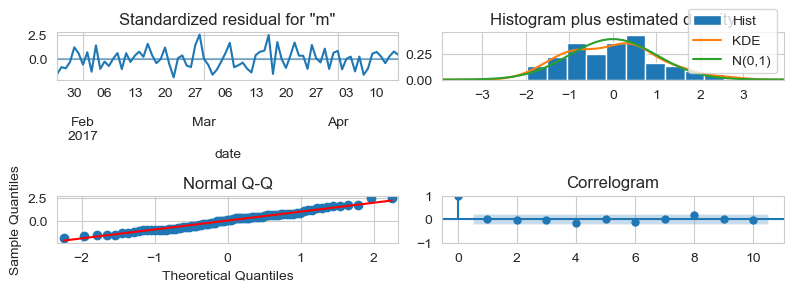

In [27]:
# Graficar los residuos
results.plot_diagnostics(figsize=(8,3))
plt.tight_layout()
plt.show()

In [28]:
# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = results.predict(start=pd.to_datetime('2017-04-15'), end=pd.to_datetime('2017-04-24')).rename('SARIMA(2,1,2)(2,1,2,7) Predicciones')
print('MAE: %.2f' % (mean_absolute_error(test, pred)))
print('RMSE: %.2f' % (np.sqrt(mean_squared_error(test, pred))))

MAE: 0.89
RMSE: 0.98


In [29]:
# Realizar predicciones
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), end=pd.to_datetime('2017-05-01'))
pred_IC = pred.conf_int()

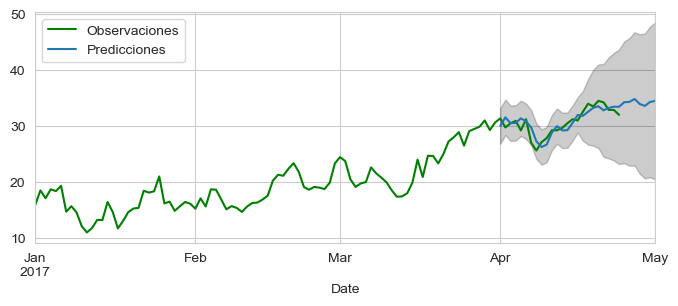

In [30]:
# Graficar la serie con predicciones
fig = df['meantemp'].plot(label='Observaciones', figsize=(8,3), color='green')
pred.predicted_mean.plot(ax=fig, label='Predicciones', xlabel='Date')
fig.fill_between(pred_IC.index, pred_IC.iloc[:,0], pred_IC.iloc[:,1], color='k', alpha=0.2)
plt.legend(loc='upper left')
plt.show()

Ajustar modelos de series de tiempos con otras librerías: `pmdarima` y `prophet`.

In [31]:
# Entrenar el modelo Auto ARIMA
from pmdarima.arima import auto_arima

model_auto = auto_arima(train, m=7)
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -205.072
Date:                Sun, 04 Sep 2022   AIC                            412.145
Time:                        09:48:12   BIC                            414.789
Sample:                             0   HQIC                           413.216
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.0217      0.394      7.660      0.000       2.249       3.795
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):                 3.03
Prob(Q):                              0.17   Pr

In [32]:
# Evaluar el modelo
pred = model_auto.predict(start=pd.to_datetime('2017-04-15'), end=pd.to_datetime('2017-05-01'))
print('MAE: %.2f' % (mean_absolute_error(test, pred)))
print('RMSE: %.2f' % (np.sqrt(mean_squared_error(test, pred))))

MAE: 1.70
RMSE: 2.02


In [33]:
# Realizar predicciones
pred, pred_IC = model_auto.predict(start=pd.to_datetime('2017-04-01'), end=pd.to_datetime('2017-05-01'), return_conf_int=True)
pred = pd.Series(pred, index=test.index)
pred_IC = pd.DataFrame(pred_IC, columns=['LB','UB'], index=test.index)

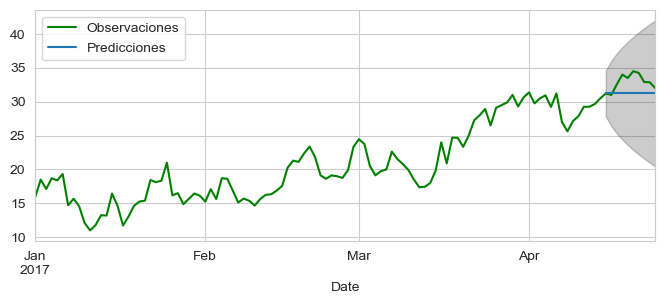

In [34]:
# Graficar la serie con predicciones
fig = df['meantemp'].plot(label='Observaciones', figsize=(8,3), color='green')
pred.plot(ax=fig, label='Predicciones', xlabel='Date')
fig.fill_between(pred_IC.index, pred_IC.iloc[:,0], pred_IC.iloc[:,1], color='k', alpha=0.2)
plt.legend(loc='upper left')
plt.show()

In [35]:
# Duplicar el conjunto de datos
df_temp = df.copy()
df_temp = df_temp.reset_index()[['date', 'meantemp']]

In [36]:
# Modificar los datos para Prophet
df_temp.columns = ['ds','y']
df_temp['ds'] = pd.to_datetime(df_temp['ds'])

In [37]:
# Entrenar el modelo Prophet
from fbprophet import Prophet

model = Prophet()
model.fit(df_temp)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
# Realizar predicciones
future = model.make_future_dataframe(periods=15, freq='D')
forecast = model.predict(future)

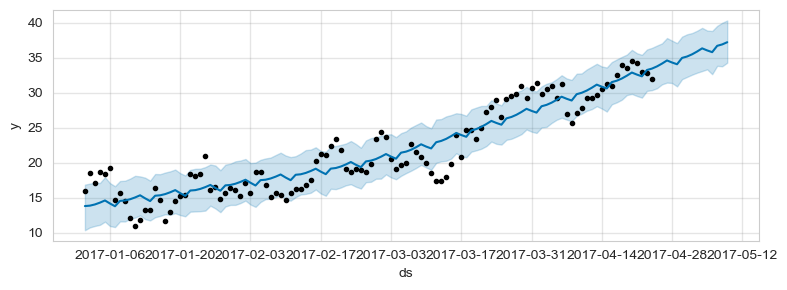

In [39]:
# Graficar la serie con predicciones
model.plot(forecast, figsize=(8,3))
plt.show()